In [29]:
#imports the required libraries
import keras
import tensorflow as tf
from tensorflow.compat.v1  import  roll
import numpy as np
import cv2
from keras import optimizers
from keras.models import *
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate, Add, Lambda, Subtract,Layer,Cropping2D,Reshape
from keras.optimizers import *
from math import pi as pi
from scipy import signal
from keras import backend as K
from math import pi as pi
import matplotlib.pyplot as plt
import math
import os
import ski

from scipy.ndimage import label, generate_binary_structure
from scipy.io import loadmat

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

from LightPipes import *


print(tf.__version__)
print(keras.__version__)

from keras.constraints import Constraint
from mpl_toolkits.axes_grid1 import make_axes_locatable

from natsort import natsorted
import glob
import imageio
from skimage.io         import imread, imsave
from skimage.measure    import regionprops
from skimage.io         import imsave

2.5.0
2.5.0


In [59]:
from skimage import img_as_ubyte


In [11]:
# Get the relative path of the root path of the project, i.e. "projet_cassioppee"
NOTEBOOK_DIR = os.getcwd()
ROOT = os.path.dirname(NOTEBOOK_DIR)
print(ROOT)

/Users/roberthajjar/Documents/projet_cassioppee


In [8]:
# set microscope and image parameters
index_downSample = 2 # downsample: index_downSample=4
wlength = 0.620*1e-6
NA = 0.75
k0 = 2 * pi / wlength
magnif = 20
spsize = (3.45*1e-6)/magnif
psize = spsize/index_downSample
crop = 84
imSize = int(crop*index_downSample)
imCenter = int(imSize / 2)
arraysize = 5.97
NAstep = 0.05
dz = 21

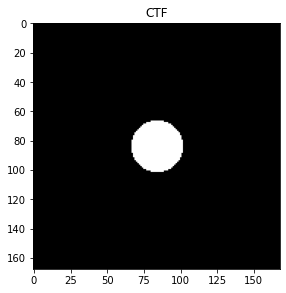

17.528225806451612


In [10]:
# Generate CTF
dkxy = 2*pi/(psize*imSize)
cutoffFrequency = (NA * k0 / dkxy)
center = [imCenter, imCenter]
kYY, kXX = np.ogrid[:imSize, :imSize]
CTF = np.sqrt((kXX - center[0]) ** 2 + (kYY - center[1]) ** 2) <= cutoffFrequency
CTF = CTF.astype(float)

# Show CTF
plt.figure(figsize=(15,15))
plt.xticks(np.arange(0,crop,20))
plt.subplot(1, 3, 3),plt.imshow(CTF[:,:], cmap='gray'),plt.title('CTF')
plt.show()

print(cutoffFrequency)

In [2]:
# Functions

# This function reads a txt file that has the led positions and puts the values into an array
def spiral_kxky(filename, ledNum):
    kxky = [[], []]
    with open(filename, 'r') as file:
        for line in file:
            for j, value in enumerate(line.split(",")):
                kxky[j].append(np.float(value))
    kxky = np.asarray(kxky)
    kxky = kxky.T
    return kxky[:ledNum, :]

# This function shows the result of the neural network result, does the Fourier 
# inverse transform from the weights of the complex object and thus as a result
# has the reconstructed image in phase and intensity

def show_result(model, show=0, noShow=10,size=10):
    w_conv_Or = model.get_layer('O_FTr').get_weights()
    w_conv_Oi = model.get_layer('O_FTi').get_weights()
    w_conv_Or_array = np.asarray(w_conv_Or)
    w_conv_Oi_array = np.asarray(w_conv_Oi)
    c_real = w_conv_Or_array[0, :, :, 0].reshape((imSize, imSize))
    c_imag = w_conv_Oi_array[0, :, :, 0].reshape((imSize, imSize))
    
    c_complex = c_real + 1j * c_imag
    c_abs = np.abs(c_complex)
    c_phase = np.angle(c_complex+pi)
    im_spatial = np.abs(np.fft.ifft2(np.fft.ifftshift(c_complex)))
    im_phase = np.angle(np.fft.ifft2(np.fft.ifftshift(c_complex)))
    
    if show:
        plt.figure(figsize=(size,size))
        plt.subplot(233),plt.imshow(np.log(c_abs[noShow:imSize-noShow, noShow:imSize-noShow]+1), cmap='gray'),plt.title('recover (abs)')
        ax = plt.subplot(232)
        plot = plt.imshow(im_phase[noShow:imSize-noShow, noShow:imSize-noShow], cmap='gray')
        divider = make_axes_locatable(ax)
        plt.title('recover (phase)')
        cax = divider.append_axes("right", size="5%", pad=0.02)
        plt.colorbar(plot,cax=cax)
        plt.subplot(231),plt.imshow(im_spatial[noShow:imSize-noShow, noShow:imSize-noShow], cmap='gray'),plt.title('recover FT')
        plt.show()
        plt.show()
        
    return c_complex

# This function creates a custom layer in the neural network 
class MyLayer( Layer):
    def __init__(self, output_dims, **kwargs):
        self.output_dims = output_dims

        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                      shape=self.output_dims,
                                      initializer='ones',
                                      trainable=True)

        super(MyLayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x, index_downSample = 2, wlength = 0.620*1e-6, NA = 0.75, magnif = 20, crop = 84, arraysize = 5.97, NAstep = 0.05, dz = 21):
        k0 = 2 * pi / wlength
        spsize = (3.45*1e-6)/magnif
        psize = spsize/index_downSample
        imSize = int(crop*index_downSample)
        imCenter = int(imSize / 2)
        a = tf.keras.backend.reshape(x, shape=(-1,imSize,imSize,1))
        return tf.multiply(a,self.kernel)

    def compute_output_shape(self, input_shape):
        return (self.output_dims)

# This function creates a custom layer in the neural network 
# which takes only the led position that is being used in the training example 
class take_one( Layer):
    def __init__(self, output_dims, **kwargs):
        self.output_dims = output_dims

        super(take_one, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                      shape=self.output_dims,
                                      initializer='ones',
                                      trainable=False)

        super(take_one, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        b = tf.keras.backend.reshape(x, shape=(1,1))
        a = tf.keras.backend.cast(b, dtype='int32')
        return a[:,0]*1

    def compute_output_shape(self, input_shape):
        return (self.output_dims)

# This function limits the weight value between a minimum and maximum value 
class Between(Constraint):
    def __init__(self, min_value, max_value):
        self.min_value =  min_value
        self.max_value = max_value

    def __call__(self, w):        
        return K.clip(w, self.min_value, self.max_value)

    def get_config(self):
        return {'min_value': self.min_value,
                'max_value': self.max_value}

# This function is a custom neural network layer that does the linear matching between inputs and weights
class ConvexCombination(Layer):
    def __init__(self, **kwargs):
        super(ConvexCombination, self).__init__(**kwargs)

    def build(self, input_shape):
        self.lambd2 = self.add_weight(name='lambda2',
                                     shape=(10,1),  # Adding one dimension for broadcasting
                                     initializer='ones',  # Try also 'ones' and 'uniform'
                                     trainable=True,constraint =Between(-1.,1.) )
        super(ConvexCombination, self).build(input_shape)

    def call(self, x):
        # x is a list of two tensors with shape=(batch_size, H, T)
        h1,h2,h3,h4,h5,h6,h7,h8,h9,h10 = x
        a= self.lambd2[0,0]
        b= self.lambd2[1,0]
        c= self.lambd2[2,0]
        d= self.lambd2[3,0]
        e= self.lambd2[4,0]
        f= self.lambd2[5,0]
        g= self.lambd2[6,0]
        h= self.lambd2[7,0]
        i= self.lambd2[8,0]
        j= self.lambd2[9,0]
        # k= self.lambd2[10,0]
        # l= self.lambd2[11,0]

        new_ctf = a*h1 + b*h2 +  c*h3 + d*h4 + e*h5 + f*h6 + g*h7 + h*h8+i*h9 +j*h10#+ k*h11 +l*h12
        return new_ctf

    def compute_output_shape(self, input_shape):
        return input_shape[0]

# try to make a custom layer to optimize the LED positions
class pos_cal(Layer):
    def __init__(self, **kwargs):
        super(pos_cal, self).__init__(**kwargs)

    def build(self, input_shape):
        self.lambd2 = self.add_weight(name='lambda2',
                                     shape=(1,1),  # Adding one dimension for broadcasting
                                     initializer='ones',  # Try also 'ones' and 'uniform'
                                     trainable=True,constraint =Between(-1.,1.) )
        super(pos_cal, self).build(input_shape)

    def call(self, x):
        # x is a list of two tensors with shape=(batch_size, H, T)
        a= self.lambd2[0,0]
        new_pos = x+a
        return new_pos

    def compute_output_shape(self, input_shape):
        return input_shape

        
def add_margin(pil_img, top, right, bottom, left, color):
    width, height = pil_img.size
    new_width = width + right + left
    new_height = height + top + bottom
    result = Image.new(pil_img.mode, (new_width, new_height), color)
    result.paste(pil_img, (left, top))
    return result


In [4]:
# Creates the neural network 
def create_model(index_downSample = 2, wlength = 0.620*1e-6, NA = 0.75, magnif = 20, crop = 84, arraysize = 5.97, NAstep = 0.05, dz = 21):
    k0 = 2 * pi / wlength
    spsize = (3.45*1e-6)/magnif
    psize = spsize/index_downSample
    imSize = int(crop*index_downSample)
    imCenter = int(imSize / 2)
    center = imSize/2

    # Initializes input layers 
    input_all = Input((imSize*imSize+2, 1),dtype='complex64', name='input_all')  # CTF input + led positions
    input_measurement = Input((crop, crop, 1), name='input_measurement')  # low-resolution images
    nule = Input((imSize,imSize, 1),dtype='float32', name='input_nule')  # CTF tf.ones(tf.shape(input_CTF), tf.float32)

    hx = int(center-crop/2)
    hy = int(center +crop/2)

    # Separates the input_all layer into CTF and led positions
    input_CTF = Lambda(lambda x: x[:,:imSize*imSize,:],name='input_CTF')(input_all)
    input_kx = Lambda(lambda x:  tf.math.real(x[:,imSize*imSize:imSize*imSize+1,:]),name='input_kx')(input_all)
    input_ky = Lambda(lambda x: tf.math.real(x[:,imSize*imSize+1:imSize*imSize+2,:]),name='input_ky')(input_all)

    # Initializes the input layers for each Zernike polynomial
    z1 = Input((imSize*imSize, 1),dtype='float', name='z1')  # CTF
    z2 = Input((imSize*imSize, 1),dtype='float', name='z2')  # CTF
    z3 = Input((imSize*imSize, 1),dtype='float', name='z3')  # CTF
    z4 = Input((imSize*imSize, 1),dtype='float', name='z4')  # CTF
    z5 = Input((imSize*imSize, 1),dtype='float', name='z5')  # CTF
    z6 = Input((imSize*imSize, 1),dtype='float', name='z6')  # CTF
    z7 = Input((imSize*imSize, 1),dtype='float', name='z7')  # CTF
    z8 = Input((imSize*imSize, 1),dtype='float', name='z8')  # CTF
    z9 = Input((imSize*imSize, 1),dtype='float', name='z9')  # CTF
    z10 = Input((imSize*imSize, 1),dtype='float', name='z10')  # CTF
    z11 = Input((imSize*imSize, 1),dtype='float', name='z11')  # CTF
    z12 = Input((imSize*imSize, 1),dtype='float', name='z12')  # CTF

    # Selects only the led position of the example that is currently running in the neural network 
    kx_i = take_one((1,),input_shape = (1,1))(input_kx)
    ky_i = take_one((1,),input_shape = (1,1))(input_ky)

    # define O (FT)
    O_FTr = MyLayer((imSize, imSize, 1), input_shape= (imSize* imSize, 1), name='O_FTr')
    O_FTi = MyLayer((imSize, imSize, 1), input_shape= (imSize* imSize, 1), name='O_FTi')

    # define P - Pupil 
    P_r = MyLayer((imSize, imSize, 1), input_shape= (imSize* imSize, 1), name='P_r')
    P_i = MyLayer((imSize, imSize, 1), input_shape= (imSize* imSize, 1), name='P_i')

    # Divides the CTF into real and imaginary parts
    CTFr = Lambda(lambda x: tf.math.real(x))(input_CTF)
    CTFi = Lambda(lambda x: tf.math.imag(x))(input_CTF)

    # Linear combination of Zernike polynomials: 
    Comb = ConvexCombination(name='inter_z1')([z1,z2,z3,z4,z5,z6,z7,z8,z9,z10])

    # Defines the pupil as a combination of the Zernike polynomials
    Pupil = Lambda(lambda x: tf.exp(1j*tf.cast(x[0],tf.complex64))*x[1],name='Pupil')([Comb,input_CTF])

    # Divides the Pupil into real and imaginary parts
    Pupil_r = Lambda(lambda x: tf.math.real(x))(Pupil)
    Pupil_i = Lambda(lambda x: tf.math.imag(x))(Pupil)

    # P*Pupil
    P_cr = P_r(Pupil_r)
    P_ci = P_i(Pupil_i)

    # Multiplies the complex object by a null image
    Or = O_FTr(nule)
    Oi = O_FTi(nule)

    # Moves the complex object according to the led positions 
    Or_d =  Lambda(lambda x: roll(x[0],shift=[x[1][0],x[2][0]],axis=[1,2]),name='Roll_Or')([Or,kx_i,ky_i])  
    Oi_d =  Lambda(lambda x: roll(x[0],shift=[x[1][0],x[2][0]],axis=[1,2]),name='Roll_Oi')([Oi,kx_i,ky_i])

    # Pupil Multiplication with the Complex Object
    CrOr_c = Lambda(lambda x: tf.multiply(x[0],x[1]))([P_cr,Or_d])
    CiOi_c = Lambda(lambda x: tf.multiply(x[0],x[1]))([P_ci,Oi_d])
    CrOi_c = Lambda(lambda x: tf.multiply(x[0],x[1]))([P_cr,Oi_d])
    CiOr_c = Lambda(lambda x: tf.multiply(x[0],x[1]))([P_ci,Or_d])

    # Cuts the generated result according to index down Sample
    CrOr = Lambda(lambda x: tf.image.central_crop(x, 1/index_downSample ),name='Crop_CrOr')(CrOr_c)
    CiOi = Lambda(lambda x: tf.image.central_crop(x, 1/index_downSample ),name='Crop_CiOi')(CiOi_c)
    CrOi = Lambda(lambda x: tf.image.central_crop(x, 1/index_downSample ),name='Crop_CrOi')(CrOi_c)
    CiOr = Lambda(lambda x: tf.image.central_crop(x, 1/index_downSample ),name='Crop_CiOr')(CiOr_c)

    # generate low resolution image (FT)
    lowFT_r = Subtract(name='lowFT_r')([CrOr, CiOi])
    lowFT_i = Add(name='lowFT_i')([CrOi, CiOr])

    lowFT = Lambda(lambda x: tf.cast(x[0], tf.complex64) + 1j * tf.cast(x[1], tf.complex64),name='lowFT')([lowFT_r, lowFT_i])
    # do ifft
    im_iFT = Lambda(lambda x: tf.signal.ifft3d(tf.roll(tf.cast(x, tf.complex64),[int(imSize/2), int(imSize/2)], axis=[0, 1])),name='low_iFT')(lowFT)

    image = Lambda(lambda x: tf.abs(x))(im_iFT)

    # keep angle, and use sqrt(I) to change the amplitude
    iFT_angle = Lambda(lambda x: tf.math.angle(tf.cast(x, tf.complex64)),name='low_iFT_angle')(im_iFT)

    sqrtI = Lambda(lambda x: tf.sqrt(x),name='input_amp')(input_measurement)

    output = Lambda(lambda x: tf.multiply(tf.cast(tf.divide(tf.reduce_sum(x[0]),tf.reduce_sum(x[1])), tf.float32),x[2]),output_shape=(crop,crop,1),name='out')([sqrtI, image,image])

    model = Model(inputs=[input_all,input_measurement,nule,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10], outputs=[output])
    #model.summary()

    return model

    #keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)



In [5]:
# Function that removes the background from the image according to the segmentation that has already been done
def extract_imagette(image, labeled,raw, coords_para, coords_distrac,cells_mean=60, size1=71, size2=71, 
                     travel_output=os.getcwd()+"_output/", tophat=False, zoro=False,mask=False):
  
    for region in regionprops(labeled):

        image_sortie=np.zeros([size1,size2], dtype='uint8')

        if region.equivalent_diameter>cells_mean*2/3:

            coords = region.coords
            
            #imagette image
            image_sortie[coords[:,0],coords[:,1]]=\
            image[coords[:,0],coords[:,1]]

            imsave(travel_output, image_sortie)

def fpm_save_cell():
    # set microscope and image parameters
    index_downSample = 2 # downsample: index_downSample=4
    wlength = 0.620*1e-6
    NA = 0.75
    k0 = 2 * pi / wlength
    magnif = 20
    spsize = (3.45*1e-6)/magnif
    psize = spsize/index_downSample
    crop = 84
    imSize = int(crop*index_downSample)
    imCenter = int(imSize / 2)
    arraysize = 5.97
    NAstep = 0.05
    dz = 21

    # Generate CTF
    dkxy = 2*pi/(psize*imSize)
    cutoffFrequency = (NA * k0 / dkxy)
    center = [imCenter, imCenter]
    kYY, kXX = np.ogrid[:imSize, :imSize]
    CTF = np.sqrt((kXX - center[0]) ** 2 + (kYY - center[1]) ** 2) <= cutoffFrequency
    CTF = CTF.astype(float)

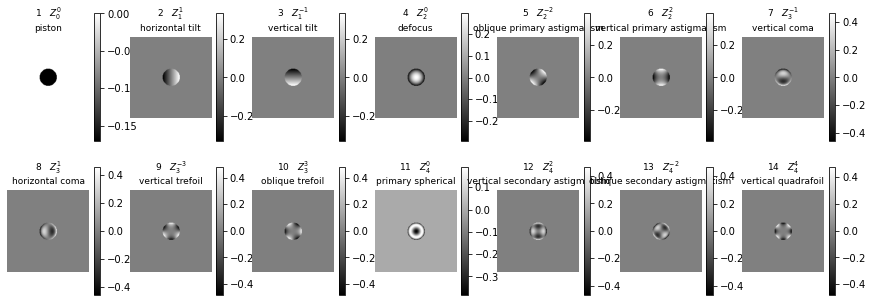

In [16]:
### Show CTF
##plt.figure(figsize=(15,15))
##plt.xticks(np.arange(0,crop,20))
##plt.subplot(1, 3, 3),plt.imshow(CTF[:,:], cmap='gray'),plt.title('CTF')
##plt.show()

##print(cutoffFrequency)

# Import the library and create the Zernike polynomials to be used in the neural network  
import matplotlib.pyplot as plt
import math
    
wavelength=wlength
cutoffFrequency = (NA * k0 / dkxy)

size=cutoffFrequency
N=imSize
A=wavelength/(N/2*math.pi)

poly = np.ndarray([21,imSize,imSize],dtype=np.float64)

plt.figure(figsize=(15,8)) 
for Noll in range (1,15):
    (nz,mz)=noll_to_zern(Noll)
    S=ZernikeName(Noll)
    F=Begin(N,psize,N)
    F=Zernike(nz,mz,size,A,F)
    F=CircAperture(size,0,0,F)
    Phi=Phase(F)
    Z = Phi
    poly[Noll-1] = Z
        
    #ax1 = plt.subplot(3,7,Noll)
    #plot = plt.imshow(np.real(Z), cmap='gray')
    #plt.colorbar(plot,ax=ax1)
    #s=repr(Noll) + '  ' + ' $Z^{'+repr(mz)+'}_{'+repr(nz)+'}$' + '\n' + S
    #plt.title(s, fontsize=9);plt.axis('off')

    ax1 = plt.subplot(3,7,Noll)
    plot = plt.imshow(poly[Noll-1], cmap='gray')
    plt.colorbar(plot,ax=ax1)
    s=repr(Noll) + '  ' + ' $Z^{'+repr(mz)+'}_{'+repr(nz)+'}$' + '\n' + S
    plt.title(s, fontsize=9);plt.axis('off')
plt.show()

In [17]:
# Remove unnecessary variables

del Z,Phi,S,F

z1_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF
z2_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF
z3_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF
z4_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF
z5_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF
z6_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF
z7_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF
z8_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF
z9_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF
z10_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF

for i in range(int(arraysize ** 2)):
    z1_input[i, :, 0]  = np.reshape(poly[0],(imSize*imSize))
    z2_input[i, :, 0]  = np.reshape(poly[1],(imSize*imSize))
    z3_input[i, :, 0]  = np.reshape(poly[2],(imSize*imSize))
    z4_input[i, :, 0]  = np.reshape(poly[3],(imSize*imSize))
    z5_input[i, :, 0]  = np.reshape(poly[4],(imSize*imSize))
    z6_input[i, :, 0]  = np.reshape(poly[5],(imSize*imSize)) 
    z7_input[i, :, 0]  = np.reshape(poly[6],(imSize*imSize)) 
    z8_input[i, :, 0]  = np.reshape(poly[7],(imSize*imSize)) 
    z9_input[i, :, 0]  = np.reshape(poly[8],(imSize*imSize)) 
    z10_input[i, :, 0]  = np.reshape(poly[9],(imSize*imSize))
del poly

In [20]:
# Reads the positions of the leds that have been estimated and placed in a txt document
path_pos_led = os.path.join(ROOT, 'data/positions_des_leds/pos_all_2.txt')
kakr = spiral_kxky(path_pos_led,int( arraysize ** 2)) # load kx, ky here
#print('kxky shape:',kakr.shape)

kx_i = np.ndarray((int(arraysize ** 2),1,1),dtype=np.float32) # input measurement
ky_i = np.ndarray((int(arraysize ** 2),1,1),dtype=np.float32) # input measurement

# The following part makes optimizations of the positions 
# from the genetic algorithm, it can be removed if you want 
# to work only with the original estimation 

kakr[1,0] = kakr[1,0] +14.76734925
kakr[1,1] = kakr[1,1] +	0.59890099

kakr[2,0] = kakr[2,0] +14.89285647
kakr[2,1] = kakr[2,1] +0.92978567

kakr[3,0] = kakr[3,0] + 14.10572814 
kakr[3,1] = kakr[3,1] - 0.05350908

kakr[4,0] = kakr[4,0] + 14.70121004
kakr[4,1] = kakr[4,1] -0.96501889

kakr[5,0] = kakr[5,0] +14.02508033
kakr[5,1] = kakr[5,1] + 0.82702106

kakr[6,0] = kakr[6,0] + 14.97020396
kakr[6,1] = kakr[6,1] -  0.0542885

kakr[7,0] = kakr[7,0] -14.96710334  
kakr[7,1] = kakr[7,1] -0.77540696

kakr[9,0] = kakr[9,0] + 3.36549871
kakr[9,1] = kakr[9,1]  -0.40575659

kakr[11,0] = kakr[11,0] + 6.61696441 
kakr[11,1] = kakr[11,1] -0.65608742

kakr[12,0] = kakr[12,0] + 6.93462461 
kakr[12,1] = kakr[12,1] + 0.29434819

kakr[13,0] = kakr[13,0] + 5.15290666 
kakr[13,1] = kakr[13,1] + 0.62740655

kakr[14,0] = kakr[14,0] + 4.9515296
kakr[14,1] = kakr[14,1] + 0.46726247

kakr[15,0] = kakr[15,0] + 0.88872929 
kakr[15,1] = kakr[15,1] -0.00710684

kakr[16,0] = kakr[16,0] + 3.60385903 
kakr[16,1] = kakr[16,1] + 0.46693824

kakr[18,0] = kakr[18,0] -14.55634447  
kakr[18,1] = kakr[18,1] +  0.74065819

# It transforms the led positions that are in x,y into kx and ky. 
for i in range(35):
    kx_i[i,0,0] = (kakr[i,0]*(crop/500))*np.cos(kakr[i,1])
    ky_i[i,0,0] = (kakr[i,0]*(crop/500))*np.sin(kakr[i,1])
    print(kakr[i])

[0. 0.]
[64.26541138  3.22134753]
[64.3909186  -1.49266087]
[64.10572814 -1.42430545]
[64.19927217 -1.23416503]
[63.52314246  1.3461672 ]
[64.97020396  1.51650787]
[80.37730279  2.19456751]
[95.99999237  3.54159274]
[98.70990484 -2.52573096]
[95.34440613 -1.59241457]
[104.61696441  -1.72688374]
[107.27902311  -0.27982981]
[106.99731279   0.55578824]
[106.95153723   0.91726246]
[102.23313542   0.91451144]
[100.94825753   1.91611627]
[101.           1.93079639]
[84.78806166  3.18307295]
[92.92370605  3.10006309]
[93.         -2.84159255]
[92.         -2.39159255]
[91.92371368 -2.00006323]
[91.37973022 -1.60619431]
[91.92369843 -1.21232574]
[92.         -0.82079642]
[91.92370605 -0.4292668 ]
[ 9.13797302e+01 -3.53981733e-02]
[91.92369843  0.35847044]
[92.          0.75000001]
[91.92371368  1.14152957]
[91.92369843  1.47926676]
[92.          1.87079632]
[91.92369843  2.26232576]
[91.37973022  2.65619445]


In [67]:
import time
original =np.ndarray((35, crop, crop))

path_log = os.path.join(ROOT, 'data/outputs/save_segmentation')
login = path_log

print(os.listdir(login))

# Select which cell samples you will work with, knowing that for patient CAT01 we have 10 samples in total 
list_log = os.listdir(login)
    

for log in list_log:
    print(log)
    travel = login+'/'+log

    infected = []
    healthy =[]

    path_output = os.path.join(ROOT, 'data/outputs/fpm_84/CAT01/' + log+'/')
    travel_output = path_output

    if not os.path.exists(travel_output):
        os.makedirs(travel_output)
        
    for arch in os.listdir(travel):
        if 'infected' in arch:
            infected.append(arch)
        if 'healthy' in arch:
            healthy.append(arch)

    print(len(healthy))

    count = 0 
    # Cut off the number of cells you are going to make the FPM
    #healthy = healthy[1300:]
    print(healthy)

    # If you want to do with infected cells change the ch to ch=infected[i] (line 38) and also the for to "for i in range(len(infected)) (line 37)"
    for i in range(len(healthy)):
        ch = healthy[i]
        start = time.time()
        tf.keras.backend.clear_session()
        title1 = '_' + ch +'_phase.png'
        title2 = '_' + ch +'_inten.png'
        i = 0
        celule = travel + "/" + ch +'/' #############
        original =np.ndarray((35, crop, crop))

        #for image_path in natsorted(glob.glob(celule+'*.png')):
        #  image = imageio.imread(image_path)
        #  if 'mask' in image_path:
        #    original[i] = cv2.fastNlMeansDenoising(image,None,3,7,15)  
        #    i = i+1
        #  else:
        #    mask = image
        
        for image_path in os.listdir(celule):
            image = imageio.imread(celule+image_path)
            if "mask" in image_path:
                original[i] = cv2.fastNlMeansDenoising(image, None, 3, 7, 15)
                i = i+1
            else:
                mask = image
        
        divs = original.copy()
        
        cell = divs

        # Generate CTFs
        imgs_train_input1 = np.ndarray((int(arraysize ** 2), imSize, imSize, 1),dtype=np.complex64) # input CTF
        imgs_train_input2 = np.ndarray((int(arraysize ** 2), crop, crop, 1)) # input CTF
        imgs_train_input4 = np.ndarray((int(arraysize ** 2), imSize, imSize, 1),dtype=np.float32) # input CTF

        for i in range(int(arraysize ** 2)):
            imgs_train_input2[i, :, :, 0] = cell[i]
            imgs_train_input1[i, :, :, 0] = CTF.astype(np.complex64)
            imgs_train_input4[i, :, :, 0] = np.ones(( imSize, imSize),np.float32)

        imgs_train_input3 = np.reshape(imgs_train_input1,(int(arraysize ** 2),imSize* imSize, 1))

        imgs_train_input3 = np.concatenate((imgs_train_input3,kx_i,ky_i),axis=1)

        model = create_model()

        weight_or = np.ndarray((1, imSize, imSize, 1))
        weight_oi = np.ndarray((1, imSize, imSize, 1))

        weight_pr = np.ndarray((1, imSize, imSize, 1))
        weight_pi = np.ndarray((1, imSize, imSize, 1))

        weight_z1 = np.zeros((10, 1))

        imgs_test_predict = np.sqrt(imgs_train_input2)

        # set low res image FT as the initial weight
        imlowFT1 = np.fft.fftshift(np.fft.fft2(np.sqrt( rescale(imgs_train_input2[0, :, :, 0], index_downSample,anti_aliasing=False)))).astype(np.complex128)
        weight_or[0, :, :, 0] = np.real(imlowFT1)
        weight_oi[0, :, :, 0] = np.imag(imlowFT1)

        model.get_layer('O_FTr').set_weights(weight_or)
        model.get_layer('O_FTi').set_weights(weight_oi)
        model.get_layer('inter_z1').set_weights([weight_z1])

        model.get_layer('P_r').trainable = False
        model.get_layer('P_i').trainable = False
        model.get_layer('O_FTr').trainable = False
        model.get_layer('O_FTi').trainable = False
        model.get_layer('inter_z1').trainable = True

        # Trains the neural net only the layer of Zernike polynomials 
        adam = optimizers.adagrad_v2.Adagrad(learning_rate=0.01)
        model.compile(loss='mean_absolute_error', optimizer=adam)
        history = model.fit([imgs_train_input3, imgs_train_input2,imgs_train_input4,z1_input,z2_input,z3_input,z4_input,z5_input,z6_input,z7_input,z8_input,z9_input,z10_input],imgs_test_predict, batch_size=1, epochs=10, verbose=0, shuffle=False)


        model.get_layer('O_FTr').trainable = True
        model.get_layer('O_FTi').trainable = True
        model.get_layer('inter_z1').trainable = False

        w_conv_Or = model.get_layer('O_FTr').get_weights()
        w_conv_Oi = model.get_layer('O_FTi').get_weights()
        w_conv_Or_array = np.asarray(w_conv_Or)
        w_conv_Oi_array = np.asarray(w_conv_Oi)
        c_real = w_conv_Or_array[0, :, :, 0].reshape((imSize, imSize))
        c_imag = w_conv_Oi_array[0, :, :, 0].reshape((imSize, imSize))

        weight_or[0, :, :, 0] = c_real
        weight_oi[0, :, :, 0] = c_imag 

        model.get_layer('O_FTr').set_weights(weight_or)
        model.get_layer('O_FTi').set_weights(weight_oi)

        # Train the complex object
        adam = optimizers.rmsprop_v2.RMSProp(learning_rate=10)
        model.compile(loss="mean_absolute_error", optimizer=adam)
        history = model.fit([imgs_train_input3, imgs_train_input2,imgs_train_input4,z1_input,z2_input,z3_input,z4_input,z5_input,z6_input,z7_input,z8_input,z9_input,z10_input],imgs_test_predict, batch_size=1, epochs=10, verbose=0, shuffle=False)

        # Takes the object and performs the inverse Fourier transform to get the intensity and phase image and save it to file
        w_conv_Or = model.get_layer('O_FTr').get_weights()
        w_conv_Oi = model.get_layer('O_FTi').get_weights()
        w_conv_Or_array = np.asarray(w_conv_Or)
        w_conv_Oi_array = np.asarray(w_conv_Oi)
        c_real = w_conv_Or_array[0, int(imSize/2)-int(crop/2):int(imSize/2)+int(crop/2), int(imSize/2)-int(crop/2):int(imSize/2)+int(crop/2), 0].reshape((crop, crop))
        c_imag = w_conv_Oi_array[0, int(imSize/2)-int(crop/2):int(imSize/2)+int(crop/2), int(imSize/2)-int(crop/2):int(imSize/2)+int(crop/2), 0].reshape((crop, crop))

        c_complex = c_real + 1j * c_imag
        c_abs = np.abs(c_complex)
        c_phase = np.angle(c_complex+pi)
        im_spatial = np.abs(np.fft.ifft2(np.fft.ifftshift(c_complex)))
        im_phase = np.angle(np.fft.ifft2(np.fft.ifftshift(c_complex)))

        #classe=regionprops(mask)

        image= im_spatial
        
        #normalise image
        image = convert_uint8(image)
        
        if image.dtype!='uint8':
            img_cr=(image -image.min())/(image.max()-image.min())
            image=img_cr*255
            del img_cr
            image=np.array(image, dtype='uint8')
        extract_imagette(image, mask, coords_para=False, coords_distrac=False,raw=i,cells_mean=60, size1=crop, size2=crop,  travel_output=travel_output+title2,mask=False)


        image = im_phase
        
        #normalise image
        image = convert_uint8(image)
    
        if image.dtype!='uint8':
            img_cr=(image -image.min())/(image.max()-image.min())
            image=img_cr*255
            del img_cr
            image=np.array(image, dtype='uint8')
        extract_imagette(image, mask, coords_para=False, coords_distrac=False,raw=i,cells_mean=60, size1=crop, size2=crop,  travel_output=travel_output+title1,mask=False)
        end = time.time()
        print(count,end-start)

        count = count+1
        
        del image, imgs_train_input3, imgs_train_input1,imgs_train_input2, model,weight_or,weight_oi,weight_pr,weight_pi,weight_z1,c_imag,c_real,original
        tf.keras.backend.clear_session()
        
        tf.keras.backend.clear_session()

        #plt.figure(figsize=(15,15))
        #plt.xticks(np.arange(0,crop,20))
        #plt.subplot(1, 3, 3),plt.imshow(image, cmap='gray'),plt.title(i)
        #plt.show()

        # Create the path and save the images
        #os.makedirs(travel_output)
        
        im_spatial = img_as_ubyte(im_spatial)
        im_phase = img_as_ubyte(im_phase)
        
        imageio.imsave(travel_output+title1, im_spatial)
        imageio.imsave(travel_output+title2, im_phase)
        
        #imsave(travel_output+title1, im_spatial)
        #imsave(travel_output+title2, im_phase)

['9994A323901', '9994A323938', '9994A323947', '9994A323977', '9994A323956', '9994A323968', '9994A323986', '9994A323919', '9994A323910', '9994A323929']
9994A323901
1143
['healthy_5144', 'healthy_4250', 'healthy_4634', 'healthy_3623', 'healthy_4439', 'healthy_1379', 'healthy_3624', 'healthy_1341', 'healthy_4257', 'healthy_4859', 'healthy_5143', 'healthy_4866', 'healthy_4268', 'healthy_4892', 'healthy_4261', 'healthy_5181', 'healthy_4437', 'healthy_3612', 'healthy_1377', 'healthy_4605', 'healthy_1383', 'healthy_4295', 'healthy_5175', 'healthy_4850', 'healthy_5172', 'healthy_4292', 'healthy_4602', 'healthy_4430', 'healthy_3615', 'healthy_5186', 'healthy_4259', 'healthy_4857', 'healthy_5314', 'healthy_4490', 'healthy_3641', 'healthy_4464', 'healthy_1324', 'healthy_3679', 'healthy_1323', 'healthy_3646', 'healthy_4463', 'healthy_4497', 'healthy_2590', 'healthy_1315', 'healthy_3670', 'healthy_4203', 'healthy_5325', 'healthy_2564', 'healthy_3684', 'healthy_4499', 'healthy_3648', 'healthy_3683',

<ipython-input-67-ef7068be9727>:94: RuntimeWarning: invalid value encountered in sqrt
  imgs_test_predict = np.sqrt(imgs_train_input2)
<ipython-input-67-ef7068be9727>:97: RuntimeWarning: invalid value encountered in sqrt
  imlowFT1 = np.fft.fftshift(np.fft.fft2(np.sqrt( rescale(imgs_train_input2[0, :, :, 0], index_downSample,anti_aliasing=False)))).astype(np.complex128)


0 11.007251977920532


<ipython-input-62-6f6a3e577ad6>:3: RuntimeWarning: invalid value encountered in true_divide
  img_cr=(img -img.min())/(img.max()-img.min())


1 8.605851888656616
2 8.694205284118652
3 8.374084234237671
4 10.63150405883789
5 10.561072826385498
6 11.789732217788696
7 10.872575998306274
8 8.517806768417358
9 8.382863759994507
10 11.90077805519104
11 10.992362976074219
12 11.514577150344849
13 11.086408853530884
14 10.585049152374268
15 10.502663850784302
16 10.868252754211426
17 11.384950876235962
18 11.072142839431763
19 10.842455863952637
20 10.773285865783691
21 11.059853792190552
22 8.657421827316284
23 8.882377862930298
24 8.833422899246216
25 9.199175119400024
26 11.31196117401123
27 10.756675004959106
28 10.951401233673096
29 9.053712844848633
30 11.187240839004517
31 8.291224956512451
32 8.709556102752686
33 10.766402006149292
34 8.292437076568604
35 10.33955979347229
36 11.272653102874756
37 10.74539589881897
38 11.01032280921936
39 11.020029067993164
40 11.374226093292236
41 10.943284034729004
42 10.592297077178955
43 11.56871509552002
44 12.595902919769287
45 9.13882303237915
46 9.719019174575806
47 12.25605511665344

372 12.649696111679077
373 12.300612211227417
374 12.36182188987732
375 12.652769088745117
376 12.961996078491211
377 12.764002084732056
378 12.690217018127441
379 11.799461126327515
380 11.938800811767578
381 11.479362726211548
382 11.491856098175049
383 11.956656694412231
384 11.55682897567749
385 11.547876119613647
386 11.621521949768066
387 12.922312259674072
388 12.775354862213135
389 12.78386402130127
390 12.737744092941284
391 12.629745244979858
392 9.129883050918579
393 8.935471773147583
394 9.382349014282227
395 12.04625391960144
396 12.35771918296814
397 12.212575197219849
398 9.365562915802002
399 8.94600224494934
400 8.884376049041748
401 8.942830801010132
402 9.959525108337402
403 10.593139410018921
404 10.917788028717041
405 10.421573877334595
406 9.999711036682129
407 9.194345951080322
408 9.194623947143555
409 9.5919349193573
410 9.148226976394653
411 9.140558004379272
412 9.140751123428345
413 9.582343816757202
414 9.148120880126953
415 9.344551801681519
416 12.3881461

736 12.1713547706604
737 12.019289016723633
738 11.877783060073853
739 11.964866161346436
740 11.61545205116272
741 12.159265041351318
742 11.999275922775269
743 12.39783501625061
744 11.978880882263184
745 12.229393005371094
746 12.61672592163086
747 12.43215799331665
748 11.526036977767944
749 11.653188705444336
750 12.018370151519775
751 13.099150896072388
752 12.232154130935669
753 11.82039213180542
754 11.685720205307007
755 12.078490734100342
756 11.760853052139282
757 12.48147201538086
758 13.047163963317871
759 12.164440870285034
760 11.432654857635498
761 11.432691097259521
762 11.759469032287598
763 11.689717054367065
764 11.639916181564331
765 11.514303922653198
766 11.815615892410278
767 11.518529891967773
768 11.947406768798828
769 11.983685731887817
770 12.280773878097534
771 11.487328052520752
772 11.623893976211548
773 12.144194841384888
774 12.703540086746216
775 12.303133964538574
776 12.064512968063354
777 11.573935985565186
778 11.470083951950073
779 10.882526874542

1095 11.365173816680908
1096 11.363740921020508
1097 11.356024026870728
1098 9.106600761413574
1099 8.677541017532349
1100 8.642415761947632
1101 11.392339944839478
1102 11.738287925720215
1103 11.381612777709961
1104 11.377415895462036
1105 11.28852391242981
1106 11.60122299194336
1107 11.168919086456299
1108 8.52042293548584
1109 8.591637134552002
1110 9.013055086135864
1111 8.678316831588745
1112 8.671529293060303
1113 8.710479021072388
1114 9.12674880027771
1115 8.759284973144531
1116 8.786049127578735
1117 8.752041101455688
1118 9.115941047668457
1119 8.684869050979614
1120 8.652303218841553
1121 9.072055101394653
1122 11.247582197189331
1123 11.272367715835571
1124 11.193733215332031
1125 11.608946800231934
1126 11.278449773788452
1127 11.290564060211182
1128 11.284182071685791
1129 11.67448115348816
1130 11.338852882385254
1131 11.33066201210022
1132 11.330243110656738
1133 11.707188844680786
1134 8.62952995300293
1135 11.36081600189209
1136 8.714660167694092
1137 9.086142778396

0 8.682278156280518
1 9.091486930847168
2 10.941157817840576
3 11.391734838485718
4 11.502547979354858
5 11.640395879745483
6 11.30380892753601
7 11.28739619255066
8 11.083662748336792
9 11.824157953262329
10 11.394261121749878
11 11.341959953308105
12 11.302693128585815
13 11.67616581916809
14 11.21408200263977
15 11.229802131652832
16 11.326743841171265
17 11.691405057907104
18 11.353952884674072
19 11.389890909194946
20 11.399129152297974
21 11.246155023574829
22 11.455657005310059
23 11.502763986587524
24 11.467148065567017
25 11.830411195755005
26 11.378376960754395
27 11.259145021438599
28 11.64730715751648
29 8.566025972366333
30 11.194440841674805
31 11.184941053390503
32 11.66043210029602
33 11.269157886505127
34 8.643445014953613
35 8.683077812194824
36 11.875483751296997
37 11.434563159942627
38 11.434066772460938
39 11.431872129440308
40 11.670469760894775
41 11.301372289657593
42 11.226145029067993
43 11.63238787651062
44 12.88726282119751
45 13.003645181655884
46 13.57449

368 12.346966028213501
369 12.774802923202515
370 12.615810871124268
371 12.773548126220703
372 13.085263013839722
373 13.495642185211182
374 12.967806816101074
375 9.662035942077637
376 13.12673306465149
377 12.685004949569702
378 12.92181396484375
379 13.090110778808594
380 13.315362930297852
381 12.575762033462524
382 9.382591009140015
383 12.657777070999146
384 10.36487078666687
385 9.954729795455933
386 9.921106100082397
387 9.914052248001099
388 10.304518222808838
389 9.920763731002808
390 9.916366815567017
391 9.910653829574585
392 10.347850799560547
393 9.910016059875488
394 9.92976999282837
395 9.928430080413818
396 10.375121116638184
397 9.926708936691284
398 9.706253051757812
399 9.954275131225586
400 12.059857845306396
401 16.51002597808838
402 15.455620288848877
403 14.025365114212036
404 12.848343133926392
405 12.735548973083496
406 12.409755945205688
407 9.820888996124268
408 9.645687103271484
409 12.967249870300293
410 13.094233751296997
411 10.31709098815918
412 9.9350

729 10.229251861572266
730 10.44414496421814
731 10.56886911392212
732 11.36941123008728
733 10.884917259216309
734 10.89188289642334
735 11.049344062805176
736 13.72288990020752
737 14.286195993423462
738 16.137136697769165
739 19.119570016860962
740 19.245805978775024
741 16.469210147857666
742 14.343119859695435
743 10.530233144760132
744 9.969284296035767
745 9.951257944107056
746 9.951473951339722
747 10.698441982269287
748 10.429594993591309
749 10.619539976119995
750 10.948291063308716
751 13.961213111877441
752 13.209465026855469
753 14.86744499206543
754 16.822540998458862
755 19.452791213989258
756 21.211968898773193
757 23.11710214614868
758 24.067790985107422
759 21.109374046325684
760 18.414220094680786
761 17.417457818984985
762 17.2522611618042
763 15.988016843795776
764 15.919504880905151
765 16.34353995323181
766 17.311845779418945
767 17.220849752426147
768 17.123042821884155
769 16.581391096115112
770 16.61464238166809
771 15.91715407371521
772 15.907666206359863
773

1087 8.475879192352295
1088 10.762059211730957
1089 11.01654601097107
1090 11.147708177566528
1091 11.017215013504028
1092 10.987085103988647
1093 11.029522895812988
1094 11.21340012550354
1095 11.016511917114258
1096 11.013570070266724
1097 11.375791311264038
1098 8.280707836151123
1099 8.471419095993042
1100 8.495175838470459
1101 8.589656114578247
1102 8.496267080307007
1103 8.458663940429688
1104 8.488776922225952
1105 8.561637878417969
1106 8.518088817596436
1107 8.474475145339966
1108 8.496623992919922
1109 8.624781131744385
1110 8.50605821609497
1111 8.463268995285034
1112 8.472806215286255
1113 8.600231885910034
1114 8.486510992050171
1115 8.471101999282837
1116 8.441094875335693
1117 8.684405088424683
1118 8.482746124267578
1119 8.499513864517212
1120 8.49092984199524
1121 8.601158142089844
1122 8.450541257858276
1123 8.486320972442627
1124 8.908429861068726
1125 8.294966220855713
1126 11.016249895095825
1127 11.027580976486206
1128 11.001955270767212
1129 11.032353162765503
1

0 8.707458019256592
1 11.35496997833252
2 11.120630025863647
3 10.98462700843811
4 11.25898790359497
5 10.65241813659668
6 10.62320613861084
7 11.128000974655151
8 11.756555080413818
9 9.013967990875244
10 11.570389032363892
11 8.444884300231934
12 8.77320408821106
13 8.421913862228394
14 8.350183248519897
15 11.002503156661987
16 10.631778001785278
17 10.616430759429932
18 10.607120752334595
19 11.024521827697754
20 10.592907905578613
21 10.615488052368164
22 10.597907781600952
23 11.032157182693481
24 10.618715286254883
25 10.577538013458252
26 10.888765096664429
27 11.519160985946655
28 11.507535934448242
29 11.419772148132324
30 11.324694156646729
31 11.555102825164795
32 11.377094984054565
33 9.582567930221558
34 11.950223922729492
35 9.022408962249756
36 9.254702806472778
37 8.52298092842102


ValueError: Images of type float must be between -1 and 1.

In [62]:
def convert_uint8 (img):
    if img.dtype!='uint8':
            img_cr=(img -img.min())/(img.max()-img.min())
            img=img_cr*255
            del img_cr
            img=np.array(img, dtype='uint8')
    return(img)
